# Практическое задание 4

In [1]:
%pylab inline
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

Populating the interactive namespace from numpy and matplotlib


## Часть 1. Метод опорных векторов и калибровка вероятностней

Сгенерируем синтетические данные.

In [82]:
X, y = make_classification(
    n_samples=100000, n_features=20, n_informative=10, n_redundant=10,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

__Задание 1.__ Обучение и применение метода опорных векторов.

__(1 балл)__

Обучите метод опорных векторов. На занятиях мы проходили обычный вариант, что соответствует линейному ядру (LinearSVC/LinearSVR в scikit-learn).

In [83]:
from sklearn.svm import LinearSVC

clf = LinearSVC(max_iter =1000000)
clf.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

На тестовой части посчитайте ROC-AUC, PR-AUC. Постройте ROC и PR кривые.

precisiion = [0.49873333 0.84998323 1.        ]
recall = [1.         0.84674509 0.        ]
roc-auc =  0.8490275510923723


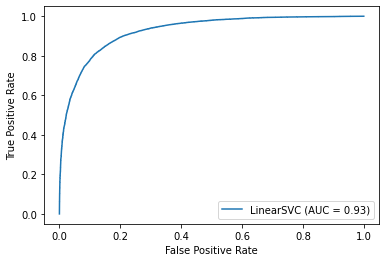

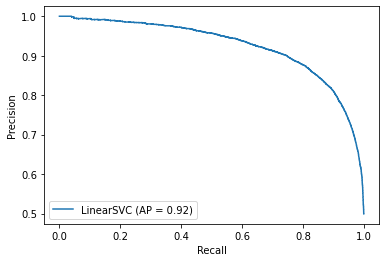

In [11]:
from sklearn.metrics import roc_auc_score,plot_roc_curve,precision_recall_curve, plot_precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, clf.predict(X_test))
print(f'precisiion = {precision}')
print(f'recall = {recall}')
print(f'roc-auc =  {roc_auc_score(y_test, clf.predict(X_test))}')
plot_roc_curve(clf,X_test, y_test)
plot_precision_recall_curve(clf,X_test, y_test)

В названии метода присутствуют некоторые "опорные векторы". Сгенерируйте синтетический датасет с помощью make_classification с 2 признаками, обучите на нём метод опорных векторов. Визуализируйте разделяющую прямую, все объекты и выделите опорные вектора (атрибут support\_vectors\_). В этот раз вместо LinearSVC воспользуйтесь SVC с линейным ядром (kernel='linear'), так как только в нём есть информация об опорных векторах.

In [12]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

# helper function for visualization

# level parameter should be tuned by hand for more convenient sight

def plot_results(model, X, y, level=1.0, cmap_objects=plt.cm.OrRd, cmap_plot=plt.cm.OrRd,
                 use_decision_function=True, plot_logreg=False):
    # plot the line, the points, and the nearest vectors to the plane
    plt.figure(1, figsize=(7, 6))
    plt.clf()

    if hasattr(model, "support_vectors_"):
        plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=150,
                    facecolors='none', zorder=10, edgecolors='k')
    plt.scatter(X[:, 0], X[:, 1], c=y, zorder=10, cmap=cmap_objects, s=50)

    plt.axis('tight')

    x_min, x_max = np.min(X[:, 0]), np.max(X[:, 0])
    x_bound = np.abs(x_max - x_min) / 10.0
    x_min -= x_bound
    x_max += x_bound

    y_min, y_max = np.min(X[:, 1]), np.max(X[:, 1])
    y_bound = np.abs(y_max - y_min) / 10.0
    y_min -= y_bound
    y_max += y_bound

    XX, YY = np.mgrid[x_min:x_max:500j, y_min:y_max:500j]

    use_Z = False
    if hasattr(model, "decision_function") and use_decision_function:
        Z = model.decision_function(np.c_[XX.ravel(), YY.ravel()])
        use_Z = True
    elif hasattr(model, "predict"):
        Z = model.predict(np.c_[XX.ravel(), YY.ravel()])
        use_Z = True

    # Put the result into a color plot
    if use_Z:
        Z = Z.reshape(XX.shape)
        plt.figure(1, figsize=(7, 6))
        plt.pcolormesh(XX, YY, Z, cmap=cmap_plot)
        if hasattr(model, "support_vectors_"):
            plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'], levels=[-level, 0, level])
        elif plot_logreg:
            plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'], levels=[-1e-10, 0, 1e+10])

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    plt.xticks(())
    plt.yticks(())
    plt.show()

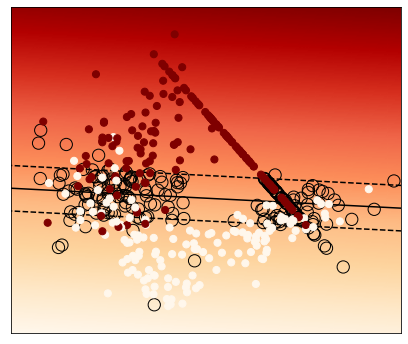

In [17]:
import sklearn.svm as svm

X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

model = svm.SVC(kernel='linear')
model.fit(X_train, y_train)
plot_results(model, X_test,y_test)

__Задание 2.__ Калибровка вероятностей.

__(1.5 балла)__

Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых. 

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины. Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной. Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [79]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 20
    for i in range(n_bins):
        l = (1.0 / n_bins) * i
        r = (1.0 / n_bins) * (i + 1)
        bin_middle_points.append((i + r - l) / 2)
        needed_elements = (preds >= l) & (preds < r)
        bin_real_ratios.append(np.mean([1] if len(y_test[needed_elements]) == 0 else y_test[needed_elements]))
    plt.plot(bin_middle_points, bin_real_ratios)

Постройте калибровочные кривые для логистической регрессии и метода опорных векторов. Изучите распределение ответов классификаторов (постройте гистограммы с помощью plt.hist). Чем они различаются? Чем вы можете объяснить это?

Заметим, что метод опорных векторов не умеет predict_proba, но имеет метод decision_function.

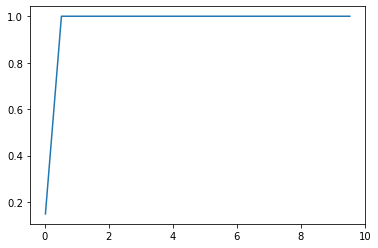

In [80]:
plot_calibration_curve(y_test, clf.predict(X_test))

(array([15095.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 14905.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

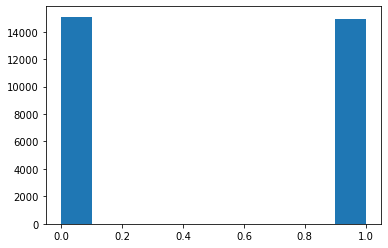

In [85]:
import matplotlib.pyplot as plt
plt.hist(clf.predict(X_test))

Воспользуйтесь CalibratedClassifierCV из sklearn для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

calibratedClassifier = CalibratedClassifierCV(clf)
calibratedClassifier.fit(X_train, y_train)

In [ ]:
plot_calibration_curve(y_test, calibratedClassifier.predict(X_test))

## Часть 2. Работа с категориальными переменными

В этой части мы научимся обрабатывать категориальные переменные, так как закодировать их в виде чисел недостаточно (это задаёт некоторый порядок, которого на категориальных переменных может и не быть). Существует два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

__Подготовка данных.__

Загрузим данные с прошлогоднего конкурса  [Kaggle Porto Seguro’s Safe Driver Prediction](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction) (вам нужна только обучающая выборка). Задача состоит в определении водителей, которые в ближайший год воспользуются своей автомобильной страховкой (бинарная классификация). Но для нас важна будет не сама задача, а только её данные. При этом под нужды задания мы немного модифицируем датасет.

In [2]:
import pandas as pd

data = pd.read_csv('train.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)

Пересемплируем выборку так, чтобы положительных и отрицательных объектов в выборке было одинаковое число. Разделим на обучающую и тестовую выборки.


In [4]:
import numpy as np
from sklearn.model_selection import train_test_split

# some resampling
np.random.seed(910)
mask_plus = np.random.choice(np.where(target == 1)[0], 100000, replace=True)
mask_zero = np.random.choice(np.where(target == 0)[0], 100000, replace=True)

data = pd.concat((data.iloc[mask_plus], data.iloc[mask_zero]))
target = np.hstack((target[mask_plus], target[mask_zero]))

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5)

__Задание 3.__ Посчитайте качество (в этом задании будем работать c ROC-AUC) на исходных признаках при применении логистической регрессии.

__(0 баллов)__

precisiion = [0.50081    0.59611714 1.        ]
recall = [1.         0.54873106 0.        ]
roc-auc =  0.5878734106149789


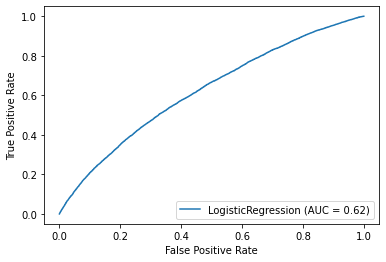

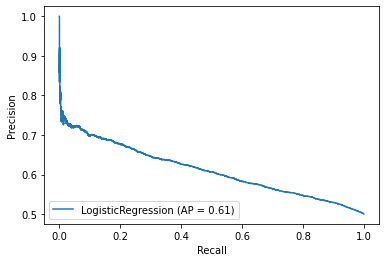

In [6]:
from sklearn.metrics import roc_auc_score,plot_roc_curve,precision_recall_curve, plot_precision_recall_curve
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter =1000000)
clf.fit(X_train, y_train)

precision, recall, _ = precision_recall_curve(y_test, clf.predict(X_test))
print(f'precisiion = {precision}')
print(f'recall = {recall}')
print(f'roc-auc =  {roc_auc_score(y_test, clf.predict(X_test))}')
plot_roc_curve(clf,X_test, y_test)
plot_precision_recall_curve(clf,X_test, y_test)

__Задание 4.__ Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (с тем, что было до кодирования). Измерьте время, потребовавшееся на обучение модели.

__(0.5 балла)__

In [ ]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(handle_unknown='ignore')
X_transformed =  one_hot_encoder.fit_transform(X_train).toarray()

clf = LogisticRegression(max_iter =1000000)
clf.fit(X_transformed[0], y_train)

precision, recall, _ = precision_recall_curve(y_test, clf.predict(X_test))
print(f'precisiion = {precision}')
print(f'recall = {recall}')
print(f'roc-auc =  {roc_auc_score(y_test, clf.predict(X_test))}')
plot_roc_curve(clf,X_test, y_test)
plot_precision_recall_curve(clf,X_test, y_test)

Как можно было заменить, one-hot-кодирование может сильно увеличивать количество признаков в датасете, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирование категориальных признаков — счётчики. Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

__Задание 5.__ Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве. Сравните время обучения с предыдущим экспериментов. Заметили ли вы что-то интересное?

__(1.5 балла)__

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
import numpy as np

ordinal_encoder = OrdinalEncoder()
X_transformed =  ordinal_encoder.fit_transform(X_train)
X_transformed = np.reshape(X_transformed,(-1,1))

clf = LogisticRegression(max_iter =1000000)
clf.fit(X_transformed[0], y_train)

precision, recall, _ = precision_recall_curve(y_test, clf.predict(X_test))
print(f'precisiion = {precision}')
print(f'recall = {recall}')
print(f'roc-auc =  {roc_auc_score(y_test, clf.predict(X_test))}')
plot_roc_curve(clf,X_test, y_test)
plot_precision_recall_curve(clf,X_test, y_test)